# Matthew Buttler Ives ML Assignment #2: Causal Inference
### Dataset used for this assignment can be found here: https://www.kaggle.com/martinellis/nhl-game-data?select=game.csv

### Similar to assignment #1 where I selected a dataset to analyze cryptocurrency prices as I am an investment and crypto enthusiast, I selected to study NHL hockey data for assignment #2 as I am interested in sports betting and talent analytics. For both of these assignments, I wanted to align my interests to my work instead of re-analyzing a dataset that I have already done for a different class.

In [1]:
# Importing correct packages from the Github example. This took awhile to upload due to issues
# installing lightgbm and causalml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Before we can start on the assignment, I have to do some basic data cleaning and preprocessing

In [2]:
# Import the game dataset
Game_Data = pd.read_csv("/Users/matthewbuttlerives/Downloads/game.csv")
# This is the main game data file that I will be using to construct my model

In [3]:
Game_Data.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT


In [4]:
Game_Data.shape
# There are over 26000 games in this dataset
# Most variables will not be useful for this analysis such as venue

(26305, 15)

In [5]:
Game_Data.dtypes

game_id                    int64
season                     int64
type                      object
date_time_GMT             object
away_team_id               int64
home_team_id               int64
away_goals                 int64
home_goals                 int64
outcome                   object
home_rink_side_start      object
venue                     object
venue_link                object
venue_time_zone_id        object
venue_time_zone_offset     int64
venue_time_zone_tz        object
dtype: object

In [6]:
Game_Data.isnull().sum()

game_id                      0
season                       0
type                         0
date_time_GMT                0
away_team_id                 0
home_team_id                 0
away_goals                   0
home_goals                   0
outcome                      0
home_rink_side_start      1196
venue                        0
venue_link                   0
venue_time_zone_id           0
venue_time_zone_offset       0
venue_time_zone_tz           0
dtype: int64

In [7]:
# Overall, the data is quite clean with onyl 1196 missing values in which rink the home team started the game on

In [8]:
# Selecting explantory variables
gd = Game_Data.iloc[:, 0:10]

In [9]:
gd["Venue_Time_Zone"]= Game_Data["venue_time_zone_tz"]

In [10]:
gd.head()

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,Venue_Time_Zone
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,PDT


In [11]:
gd = gd.drop(["date_time_GMT"],axis = 1)
# I am not interested in the start time of the game and while it could provide some value, I don't believe
# using it aligns with the purpose of this assignment 

In [12]:
# These two data sets contain observations useful for this analysis.
# The first(gp) is data for games that contain plays that occured in each game.
# The second(gts) is stat data for each team for each game
# For this project, I will be using these datasets along with gd for analysis
gp = pd.read_csv("/Users/matthewbuttlerives/Downloads/game_plays.csv")
gts = pd.read_csv("/Users/matthewbuttlerives/Downloads/game_teams_stats.csv")

In [13]:
gp.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0


In [14]:
# Unique events during a game. I am collecting this values as they will likely be grouped into the 
# gts data set to analysis how many times in games do these events occur
column_values = gp["event"].values.ravel()
unique_values =  pd.unique(column_values)
unique_values

array(['Game Scheduled', 'Period Ready', 'Period Start', 'Faceoff',
       'Shot', 'Goal', 'Takeaway', 'Hit', 'Stoppage', 'Blocked Shot',
       'Giveaway', 'Missed Shot', 'Penalty', 'Period End',
       'Period Official', 'Game End', 'Official Challenge',
       'Shootout Complete', 'Early Intermission Start',
       'Early Intermission End', 'Game Official', 'Emergency Goaltender'],
      dtype=object)

In [15]:
# Analyzing secondary shot values
column_values = gp["secondaryType"].values.ravel()
unique_values =  pd.unique(column_values)
unique_values
# The reason I included this code as it contains what kind of shot took place on goal

array([nan, 'Wrist Shot', 'Wrap-around', 'Slap Shot', 'Hooking', 'Tip-In',
       'Snap Shot', 'Backhand', 'Closing hand on puck', 'Interference',
       'Hi-sticking', 'Roughing', 'Slashing', 'Holding', 'Tripping',
       'Fighting', 'Cross checking', 'Deflected',
       'Hi stick - double minor', 'Too many men on the ice',
       'Delaying Game - Puck over glass', 'Boarding', 'Game misconduct',
       'Instigator', 'Misconduct', 'Interference - Goalkeeper', 'Kneeing',
       'PS - Tripping on breakaway', 'Delay of game', 'Holding the stick',
       'Illegal equipment', 'Unsportsmanlike conduct', 'Embellishment',
       'PS - Slash on breakaway', 'Broken stick',
       'PS - Hooking on breakaway', 'Delaying the game',
       'Instigator - Misconduct', 'Match penalty', 'Elbowing', 'Charging',
       'PS - Net displaced', 'Illegal stick',
       'Delaying Game - Illegal play by goalie', 'Illegal check to head',
       'Goalie leave crease', 'Minor', 'Bench', 'Face-off violation',
      

In [16]:
gts.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


In [17]:
### Many of these variables will be included in the model.
### I will include additional variables such as type of shot as I believe this could provide valuable insight.
### I also will examine the coordinates of where the shot took place on the ice. 
### Preprocessing on each dataset

In [18]:
gp.dtypes

play_id                 object
game_id                  int64
team_id_for            float64
team_id_against        float64
event                   object
secondaryType           object
x                      float64
y                      float64
period                   int64
periodType              object
periodTime               int64
periodTimeRemaining    float64
dateTime                object
goals_away               int64
goals_home               int64
description             object
st_x                   float64
st_y                   float64
dtype: object

In [19]:
gts.dtypes

game_id                     int64
team_id                     int64
HoA                        object
won                          bool
settled_in                 object
head_coach                 object
goals                     float64
shots                     float64
hits                      float64
pim                       float64
powerPlayOpportunities    float64
powerPlayGoals            float64
faceOffWinPercentage      float64
giveaways                 float64
takeaways                 float64
blocked                   float64
startRinkSide              object
dtype: object

In [20]:
gp.isnull().sum()
# This dataset is not as clean. With more than 4,000,000 observations, it will likley lead me to remove
# observations with missing values.

play_id                      0
game_id                      0
team_id_for             932705
team_id_against         932705
event                        0
secondaryType          3868513
x                      1134364
y                      1134333
period                       0
periodType                   0
periodTime                   0
periodTimeRemaining     193019
dateTime                     0
goals_away                   0
goals_home                   0
description                  0
st_x                   1134364
st_y                   1134364
dtype: int64

In [21]:
gts.isnull().sum()
# This dataset also has missing values but contains the most important variable, wether or not the team won.

game_id                       0
team_id                       0
HoA                           0
won                           0
settled_in                    0
head_coach                   28
goals                         8
shots                         8
hits                       4928
pim                           8
powerPlayOpportunities        8
powerPlayGoals                8
faceOffWinPercentage      22148
giveaways                  4928
takeaways                  4928
blocked                    4928
startRinkSide              2392
dtype: int64

In [22]:
### To begin analyzing the dataset, I will created two additional variables and add them to the gts dataset.
### I believe adding the type of shot to the dataset could provide valuable insight. I also believe knowing where the 
### shot took place could also add insight. 

In [23]:
# To establish what basis I need to examine shots gts
gp[["x","y"]].describe()
# The maximum value for x coordinates is 100 while the minimum value is -100
# The maximum value for y coordinates is 42 while the minimum value is -42

,x,y
count,3.916165e+06,3.916196e+06
mean,1.870930e-01,-1.592162e-01
std,6.428284e+01,2.297686e+01
min,-1.000000e+02,-4.200000e+01
25%,-6.900000e+01,-2.200000e+01
50%,0.000000e+00,0.000000e+00
75%,6.900000e+01,2.200000e+01
max,1.000000e+02,4.200000e+01


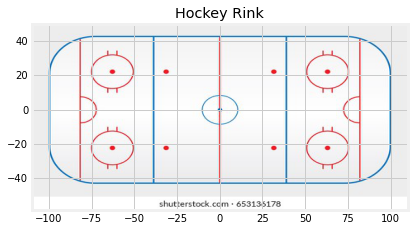

In [24]:
# Display image of a hockey rink
img = plt.imread("/Users/matthewbuttlerives/Desktop/Data Folder/vector-ice-hockey-rink-260nw-653136178.jpeg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-110, 110, -59, 50])
plt.title('Hockey Rink')
plt.show()
# This required some playing around with to align the x and y values to the image I have below,
# but now the coordinates can be displayed on this graph in a resonable proximity to their actual
# location

In [25]:
# Creating dataframe of shots on net
Shot_type = gp[(gp.secondaryType == "Wrist Shot")|
             (gp.secondaryType == "Slap Shot")|(gp.secondaryType == "Snap Shot")|
             (gp.secondaryType == "Wrap-around")|(gp.secondaryType == "Backhand")]



In [26]:
Shot_type = pd.DataFrame(Shot_type)

In [27]:
Shot_type = Shot_type.dropna()
Shot_type.isnull().sum()

play_id                0
game_id                0
team_id_for            0
team_id_against        0
event                  0
secondaryType          0
x                      0
y                      0
period                 0
periodType             0
periodTime             0
periodTimeRemaining    0
dateTime               0
goals_away             0
goals_home             0
description            0
st_x                   0
st_y                   0
dtype: int64

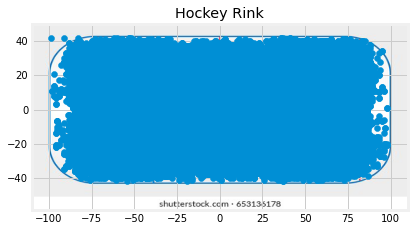

In [28]:
# First graph of all Slap Shots
df_Slap_Shot = Shot_type[(Shot_type.secondaryType == "Slap Shot")]
x_coordinates = df_Slap_Shot["x"]
y_coordinates = df_Slap_Shot["y"]
img = plt.imread("/Users/matthewbuttlerives/Desktop/Data Folder/vector-ice-hockey-rink-260nw-653136178.jpeg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-110, 110, -59, 50])
plt.scatter(x_coordinates, y_coordinates)
plt.title('Hockey Rink')
plt.show()
# Not very useful. Really the only place slapshots have never occured is directly behind the goalie net.

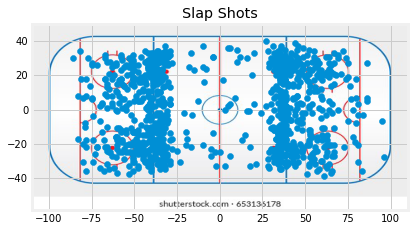

In [29]:
# Second graph of 1000 randomly selected Slap Shots
df_Slap_Shot = Shot_type[(Shot_type.secondaryType == "Slap Shot")]
df_Slap_Shot_sample = df_Slap_Shot.sample(n=1000,replace = False)
x_coordinates = df_Slap_Shot_sample["x"]
y_coordinates = df_Slap_Shot_sample["y"]
img = plt.imread("/Users/matthewbuttlerives/Desktop/Data Folder/vector-ice-hockey-rink-260nw-653136178.jpeg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-110, 110, -59, 50])
plt.scatter(x_coordinates, y_coordinates)
plt.title('Slap Shots')
plt.show()

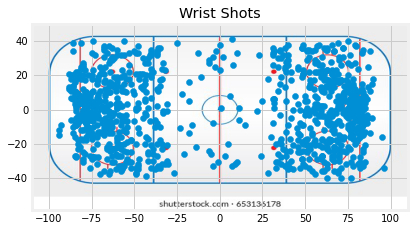

In [30]:
# Graph of 1000 randomly selected Wrist Shots
df_Wrist_Shot = Shot_type[(Shot_type.secondaryType == "Wrist Shot")]
df_Wrist_Shot_sample = df_Wrist_Shot.sample(n=1000,replace = False)
x_coordinates = df_Wrist_Shot_sample["x"]
y_coordinates = df_Wrist_Shot_sample["y"]
img = plt.imread("/Users/matthewbuttlerives/Desktop/Data Folder/vector-ice-hockey-rink-260nw-653136178.jpeg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-110, 110, -59, 50])
plt.scatter(x_coordinates, y_coordinates)
plt.title('Wrist Shots')
plt.show()

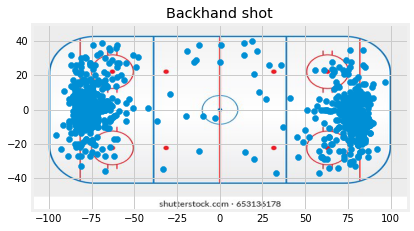

In [31]:
# Graph of 1000 randomly selected Backhand Shots
df_Backhand = Shot_type[(Shot_type.secondaryType == "Backhand")]
df_Backhand_sample = df_Backhand.sample(n=1000,replace = False)
x_coordinates = df_Backhand_sample["x"]
y_coordinates = df_Backhand_sample["y"]
img = plt.imread("/Users/matthewbuttlerives/Desktop/Data Folder/vector-ice-hockey-rink-260nw-653136178.jpeg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-110, 110, -59, 50])
plt.scatter(x_coordinates, y_coordinates)
plt.title('Backhand shot')
plt.show()

In [32]:
# I intend to add the total amount of each shot type each team took during a game to the dataset in order to provide
# more information and create a better causal analysis. I also am planning to include the coordinates of where the 
# shot was taken in order to further that analysis. For this idea, I am planning on grouping the location of shots
# based on location on the rink. If I were to break the rink into 30 quadrants, I would have an additional 150 
# variables to the dataset (5 shot types X 30 hockey quadrants). For simplicty sake, I will break the ice rink 
# into 4 quadrants by the center point of the ice rink (0,0). There is also the problem of how many shots a team
# would take in a given quadrant. If one team is on one side of the rink, they would likely not have many slapshots
# in a quadrant that is on there side of the rink taken towards there own goal. Thankfully, hockey teams switch sides 
# after the end of first peirod. So, I could either examine the number of shots taken in all three periods or just examine the number of shots
# between the first and second period with my target variable on wether or not the team won the game before the third period. A model like this
# could be used in third period betting, where bettors place bets on which team will win after the second period. 
# For this analysis. I will focus on shots, add there locations, along with total shot type to the gts dataset and 
# then prepare that for causal analysis.

In [33]:
# Define a function that will label each shot based on position on rink
def quad(Shot_type):
    if Shot_type['x'] >= 0 and Shot_type['y'] >= 0:
        return "Q1"
    elif Shot_type['x'] <=0 and Shot_type['y'] >= 0:
        return "Q2"
    elif Shot_type['x'] <= 0 and Shot_type['y'] <= 0:
        return "Q3"
    return "Q4"
Shot_type['Quadrant'] = Shot_type.apply(lambda Shot_type: quad(Shot_type), axis=1)

In [34]:
Shot_type.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,Quadrant
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0,Q2
5,2016020045_6,2016020045,16.0,4.0,Goal,Wrap-around,-88.0,5.0,1,REGULAR,56,1144.0,2016-10-19 01:41:48,0,1,"Patrick Kane (1) Wrap-around, assists: Artem A...",88.0,-5.0,Q2
7,2016020045_8,2016020045,4.0,16.0,Shot,Wrist Shot,56.0,-7.0,1,REGULAR,69,1131.0,2016-10-19 01:42:41,0,1,Dale Weise Wrist Shot saved by Corey Crawford,56.0,-7.0,Q4
11,2016020045_12,2016020045,16.0,4.0,Shot,Slap Shot,-37.0,-24.0,1,REGULAR,133,1067.0,2016-10-19 01:43:45,0,1,Duncan Keith Slap Shot saved by Michal Neuvirth,37.0,24.0,Q3
16,2016020045_17,2016020045,4.0,16.0,Shot,Wrist Shot,57.0,-20.0,1,REGULAR,168,1032.0,2016-10-19 01:44:54,0,1,Wayne Simmonds Wrist Shot saved by Corey Crawford,57.0,-20.0,Q4


In [35]:
# Selecting data for first and second 
st = Shot_type[(Shot_type.period == 1) |(Shot_type.period == 2)]

In [36]:
# Preparing to group data together
test = st[["game_id","team_id_for","secondaryType","Quadrant"]]

In [37]:
test.head()

,game_id,team_id_for,secondaryType,Quadrant
4,2016020045,16.0,Wrist Shot,Q2
5,2016020045,16.0,Wrap-around,Q2
7,2016020045,4.0,Wrist Shot,Q4
11,2016020045,16.0,Slap Shot,Q3
16,2016020045,4.0,Wrist Shot,Q4


In [38]:
# grouping by game id, team id and Quadrant to count Slap Shots
Slap_Shot_test = test[(test.secondaryType == "Slap Shot")]
testing = Slap_Shot_test[(Slap_Shot_test.Quadrant == "Q1")]
tq = testing.groupby(["game_id","team_id_for"]).size()
#sls = Slap_Shot_test.groupby(["game_id","team_id_for","Quadrant"]).size()

In [39]:
# Orginally, I broke down all Quadrants by shot_type at the same time
# Instead, I found it easier to break down the quadrants separately and them add them to the 
# gts dataset. This block is each quadrant for just Slap Shots
Q2_testing = Slap_Shot_test[(Slap_Shot_test.Quadrant == "Q2")]
tq_2 = Q2_testing.groupby(["game_id","team_id_for"]).size()
Q3_testing = Slap_Shot_test[(Slap_Shot_test.Quadrant == "Q3")]
tq_3 = Q3_testing.groupby(["game_id","team_id_for"]).size()
Q4_testing = Slap_Shot_test[(Slap_Shot_test.Quadrant == "Q4")]
tq_4 = Q4_testing.groupby(["game_id","team_id_for"]).size()

In [40]:
# grouping by game id, team id and Quadrant(s) to count Wrist Shots
Wrist_Shot_test = test[(test.secondaryType == "Wrist Shot")]
Wrist_test = Wrist_Shot_test[(Wrist_Shot_test.Quadrant == "Q1")]
tw_1 = Wrist_test.groupby(["game_id","team_id_for"]).size()
Q2_testing = Wrist_Shot_test[(Wrist_Shot_test.Quadrant == "Q2")]
tw_2 = Q2_testing.groupby(["game_id","team_id_for"]).size()
Q3_testing = Wrist_Shot_test[(Wrist_Shot_test.Quadrant == "Q3")]
tw_3 = Q3_testing.groupby(["game_id","team_id_for"]).size()
Q4_testing = Wrist_Shot_test[(Wrist_Shot_test.Quadrant == "Q4")]
tw_4 = Q4_testing.groupby(["game_id","team_id_for"]).size()

In [41]:
# grouping by game id, team id and Quadrant(s) to count Backhand Shots
Back_Shot_test = test[(test.secondaryType == "Backhand")]
Back_test = Back_Shot_test[(Back_Shot_test.Quadrant == "Q1")]
tb_1 = Back_test.groupby(["game_id","team_id_for"]).size()
Q2_testing = Back_Shot_test[(Back_Shot_test.Quadrant == "Q2")]
tb_2 = Q2_testing.groupby(["game_id","team_id_for"]).size()
Q3_testing = Back_Shot_test[(Back_Shot_test.Quadrant == "Q3")]
tb_3 = Q3_testing.groupby(["game_id","team_id_for"]).size()
Q4_testing = Back_Shot_test[(Back_Shot_test.Quadrant == "Q4")]
tb_4 = Q4_testing.groupby(["game_id","team_id_for"]).size()

In [42]:
# grouping by game id, team id and Quadrant(s) to count Snap Shots
Snap_Shot_test = test[(test.secondaryType == "Snap Shots")]
Snap_test = Snap_Shot_test[(Snap_Shot_test.Quadrant == "Q1")]
tsl_1 = Snap_test.groupby(["game_id","team_id_for"]).size()
Q2_testing = Snap_Shot_test[(Snap_Shot_test.Quadrant == "Q2")]
tsl_2 = Q2_testing.groupby(["game_id","team_id_for"]).size()
Q3_testing =Snap_Shot_test[(Snap_Shot_test.Quadrant == "Q3")]
tsl_3 = Q3_testing.groupby(["game_id","team_id_for"]).size()
Q4_testing = Snap_Shot_test[(Snap_Shot_test.Quadrant == "Q4")]
tsl_4 = Q4_testing.groupby(["game_id","team_id_for"]).size()

In [43]:
# grouping by game id, team id and Quadrant(s) to count Wrap around Shots
Wrap_Shot_test = test[(test.secondaryType == "Wrap-around")]
Wrap_test = Wrap_Shot_test[(Wrap_Shot_test.Quadrant == "Q1")]
twr_1 = Wrap_test.groupby(["game_id","team_id_for"]).size()
Q2_testing = Wrap_Shot_test[(Wrap_Shot_test.Quadrant == "Q2")]
twr_2 = Q2_testing.groupby(["game_id","team_id_for"]).size()
Q3_testing =Wrap_Shot_test[(Wrap_Shot_test.Quadrant == "Q3")]
twr_3 = Q3_testing.groupby(["game_id","team_id_for"]).size()
Q4_testing = Wrap_Shot_test[(Wrap_Shot_test.Quadrant == "Q4")]
twr_4 = Q4_testing.groupby(["game_id","team_id_for"]).size()

In [44]:
# Conversion to dataframe
# Slap Shots
tq = pd.DataFrame(tq)
tq_2 = pd.DataFrame(tq_2)
tq_3 = pd.DataFrame(tq_3)
tq_4 = pd.DataFrame(tq_4)
# Wrist Shots
tw_1 = pd.DataFrame(tw_1)
tw_2 = pd.DataFrame(tw_2)
tw_3 = pd.DataFrame(tw_3)
tw_4 = pd.DataFrame(tw_4)
#Backhand Shots
tb_1 = pd.DataFrame(tb_1)
tb_2 = pd.DataFrame(tb_2)
tb_3 = pd.DataFrame(tb_3)
tb_4 = pd.DataFrame(tb_4)
#Snap Shots
tsl_1 = pd.DataFrame(tsl_1)
tsl_2 = pd.DataFrame(tsl_2)
tsl_3 = pd.DataFrame(tsl_3)
tsl_4 = pd.DataFrame(tsl_4)
#Wrap-around
twr_1 = pd.DataFrame(twr_1)
twr_2 = pd.DataFrame(twr_2)
twr_3 = pd.DataFrame(twr_3)
twr_4 = pd.DataFrame(twr_4)


In [45]:
# Reset index for ease of use and rename columns to relevant names
tq = tq.reset_index()
tq = tq.rename(columns={0: "Total"})
tq_2 = tq_2.reset_index()
tq_2 = tq_2.rename(columns={0: "Total"})
tq_3 = tq_3.reset_index()
tq_3 = tq_3.rename(columns={0: "Total"})
tq_4 = tq_4.reset_index()
tq_4 = tq_4.rename(columns={0: "Total"})

tw_1 = tw_1.reset_index()
tw_1 = tw_1.rename(columns={0: "Total"})
tw_2 = tw_2.reset_index()
tw_2 = tw_2.rename(columns={0: "Total"})
tw_3 = tw_3.reset_index()
tw_3 = tw_3.rename(columns={0: "Total"})
tw_4 = tw_4.reset_index()
tw_4 = tw_4.rename(columns={0: "Total"})

tb_1 = tb_1.reset_index()
tb_1 = tb_1.rename(columns={0: "Total"})
tb_2 = tb_2.reset_index()
tb_2 = tb_2.rename(columns={0: "Total"})
tb_3 = tb_3.reset_index()
tb_3 = tb_3.rename(columns={0: "Total"})
tb_4 = tb_4.reset_index()
tb_4 = tb_4.rename(columns={0: "Total"})

tsl_1 = tsl_1.reset_index()
tsl_1 = tsl_1.rename(columns={0: "Total"})
tsl_2 = tsl_2.reset_index()
tsl_2 = tsl_2.rename(columns={0: "Total"})
tsl_3 = tsl_3.reset_index()
tsl_3 = tsl_3.rename(columns={0: "Total"})
tsl_4 = tsl_4.reset_index()
tsl_4 = tsl_4.rename(columns={0: "Total"})

twr_1 = twr_1.reset_index()
twr_1 = twr_1.rename(columns={0: "Total"})
twr_2 = twr_2.reset_index()
twr_2 = twr_2.rename(columns={0: "Total"})
twr_3 = twr_3.reset_index()
twr_3 = twr_3.rename(columns={0: "Total"})
twr_4 = twr_4.reset_index()
twr_4 = twr_4.rename(columns={0: "Total"})

In [46]:
# All shot types with Quadrants are recorded and grouped by game and by team.
# Now, these values must be added to the gts dataframe to begin modeling and my causal analysis.

In [47]:
gts.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


In [48]:
gts.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
0,2016020045,4,away,False,REG,Dave Hakstol,4.0,27.0,30.0,6.0,4.0,2.0,50.9,12.0,9.0,11.0,left
1,2016020045,16,home,True,REG,Joel Quenneville,7.0,28.0,20.0,8.0,3.0,2.0,49.1,16.0,8.0,9.0,left
2,2017020812,24,away,True,OT,Randy Carlyle,4.0,34.0,16.0,6.0,3.0,1.0,43.8,7.0,4.0,14.0,right
3,2017020812,7,home,False,OT,Phil Housley,3.0,33.0,17.0,8.0,2.0,1.0,56.2,5.0,6.0,14.0,right
4,2015020314,21,away,True,REG,Patrick Roy,4.0,29.0,17.0,9.0,3.0,1.0,45.7,13.0,5.0,20.0,left


In [49]:
# Alll Slap Shots for all games that occured in Q1
tq.head()

,game_id,team_id_for,Total
0,2010020002,4.0,2
1,2010020003,12.0,2
2,2010020003,30.0,2
3,2010020004,21.0,1
4,2010020005,22.0,2


In [50]:
tq.shape

(14559, 3)

In [51]:
# gts values created from 2010 due to mssing data values
# maybe group by only one quadrant at a time. That might work.
gts = gts[gts['game_id'] >= 2010020001]
gts = gts.sort_values(by="game_id",ascending=True)
gts = gts.drop_duplicates()

In [52]:
gts.head()

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide
18693,2010020001,8,away,False,REG,Jacques Martin,2.0,28.0,34.0,10.0,3.0,0.0,53.5,7.0,7.0,21.0,left
18694,2010020001,10,home,True,REG,Ron Wilson,3.0,24.0,27.0,6.0,5.0,0.0,46.5,16.0,6.0,22.0,left
17987,2010020002,4,away,True,REG,Peter Laviolette,3.0,27.0,34.0,12.0,4.0,1.0,39.3,9.0,1.0,16.0,right
17988,2010020002,5,home,False,REG,Dan Bylsma,2.0,31.0,32.0,10.0,5.0,1.0,60.7,11.0,9.0,14.0,right
15787,2010020003,12,away,True,REG,Paul Maurice,4.0,31.0,14.0,10.0,5.0,2.0,38.8,11.0,3.0,19.0,left


In [53]:
# Renaming columns to prepare for left join merge
gts = gts.rename(columns={'team_id': "team_id_for"})

In [54]:
new_df = pd.merge(gts,tq,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Slap_Shots_Q1"})

In [55]:
new_df = pd.merge(new_df,tq_2,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Slap_Shots_Q2"})

In [56]:
new_df = pd.merge(new_df,tq_3,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Slap_Shots_Q3"})

In [57]:
new_df = pd.merge(new_df,tq_4,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Slap_Shots_Q4"})

In [58]:
new_df = pd.merge(new_df,tw_1,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrist_Shots_Q1"})

In [59]:
new_df = pd.merge(new_df,tw_2,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrist_Shots_Q2"})

In [60]:
new_df = pd.merge(new_df,tw_3,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrist_Shots_Q3"})

In [61]:
new_df = pd.merge(new_df,tw_4,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrist_Shots_Q4"})

In [62]:
new_df = pd.merge(new_df,tb_1,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Backhand_Shots_Q1"})

In [63]:
new_df = pd.merge(new_df,tb_2,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Backhand_Shots_Q2"})

In [64]:
new_df = pd.merge(new_df,tb_3,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Backhand_Shots_Q3"})

In [65]:
new_df = pd.merge(new_df,tb_4,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Backhand_Shots_Q4"})

In [66]:
new_df = pd.merge(new_df,tsl_1,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Snap_Shots_Q1"})

In [67]:
new_df = pd.merge(new_df,tsl_2,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Snap_Shots_Q2"})

In [68]:
new_df = pd.merge(new_df,tsl_3,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Snap_Shots_Q3"})

In [69]:
new_df = pd.merge(new_df,tsl_4,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Snap_Shots_Q4"})

In [70]:
new_df = pd.merge(new_df,twr_1,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrap-around_Shots_Q1"})

In [71]:
new_df = pd.merge(new_df,twr_2,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrap-around_Shots_Q2"})

In [72]:
new_df = pd.merge(new_df,twr_3,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrap-around_Shots_Q3"})

In [73]:
new_df = pd.merge(new_df,twr_4,how='left', left_on=['game_id','team_id_for'], right_on=['game_id','team_id_for'])
new_df = new_df.rename(columns={'Total': "Wrap-around_Shots_Q4"})

In [74]:
new_df

,game_id,team_id_for,HoA,won,settled_in,head_coach,goals,shots,hits,pim,...,Backhand_Shots_Q3,Backhand_Shots_Q4,Snap_Shots_Q1,Snap_Shots_Q2,Snap_Shots_Q3,Snap_Shots_Q4,Wrap-around_Shots_Q1,Wrap-around_Shots_Q2,Wrap-around_Shots_Q3,Wrap-around_Shots_Q4
0,2010020001,8,away,False,REG,Jacques Martin,2.0,28.0,34.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2010020001,10,home,True,REG,Ron Wilson,3.0,24.0,27.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010020002,4,away,True,REG,Peter Laviolette,3.0,27.0,34.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,2010020002,5,home,False,REG,Dan Bylsma,2.0,31.0,32.0,10.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010020003,12,away,True,REG,Paul Maurice,4.0,31.0,14.0,10.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25325,2019040651,87,home,True,tbc,Bruce Cassidy,9.0,22.0,1.0,0.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
25326,2019040652,90,away,True,tbc,Rick Tocchet,10.0,28.0,0.0,0.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25327,2019040652,89,home,False,tbc,Craig Berube,5.0,17.0,0.0,0.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25328,2019040653,90,home,True,tbc,Rick Tocchet,5.0,20.0,0.0,0.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
new_df[['Slap_Shots_Q1','Slap_Shots_Q2','Slap_Shots_Q3','Slap_Shots_Q4'
       ,'Wrist_Shots_Q1','Wrist_Shots_Q2','Wrist_Shots_Q3','Wrist_Shots_Q4'
       ,'Backhand_Shots_Q1','Backhand_Shots_Q2','Backhand_Shots_Q3','Backhand_Shots_Q4'
       ,'Snap_Shots_Q1','Snap_Shots_Q2','Snap_Shots_Q3','Snap_Shots_Q4'
       ,"Wrap-around_Shots_Q1","Wrap-around_Shots_Q2","Wrap-around_Shots_Q3","Wrap-around_Shots_Q4"
       ]] = new_df[['Slap_Shots_Q1','Slap_Shots_Q2','Slap_Shots_Q3','Slap_Shots_Q4'
       ,'Wrist_Shots_Q1','Wrist_Shots_Q2','Wrist_Shots_Q3','Wrist_Shots_Q4'
       ,'Backhand_Shots_Q1','Backhand_Shots_Q2','Backhand_Shots_Q3','Backhand_Shots_Q4'
       ,'Snap_Shots_Q1','Snap_Shots_Q2','Snap_Shots_Q3','Snap_Shots_Q4'
       ,"Wrap-around_Shots_Q1","Wrap-around_Shots_Q2","Wrap-around_Shots_Q3","Wrap-around_Shots_Q4"
       ]].fillna(0)

In [76]:
pd.set_option('display.max_columns', None)
new_df.head(100)

,game_id,team_id_for,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,Slap_Shots_Q1,Slap_Shots_Q2,Slap_Shots_Q3,Slap_Shots_Q4,Wrist_Shots_Q1,Wrist_Shots_Q2,Wrist_Shots_Q3,Wrist_Shots_Q4,Backhand_Shots_Q1,Backhand_Shots_Q2,Backhand_Shots_Q3,Backhand_Shots_Q4,Snap_Shots_Q1,Snap_Shots_Q2,Snap_Shots_Q3,Snap_Shots_Q4,Wrap-around_Shots_Q1,Wrap-around_Shots_Q2,Wrap-around_Shots_Q3,Wrap-around_Shots_Q4
0,2010020001,8,away,False,REG,Jacques Martin,2.0,28.0,34.0,10.0,3.0,0.0,53.5,7.0,7.0,21.0,left,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2010020001,10,home,True,REG,Ron Wilson,3.0,24.0,27.0,6.0,5.0,0.0,46.5,16.0,6.0,22.0,left,0.0,1.0,1.0,0.0,3.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010020002,4,away,True,REG,Peter Laviolette,3.0,27.0,34.0,12.0,4.0,1.0,39.3,9.0,1.0,16.0,right,2.0,0.0,1.0,0.0,1.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2010020002,5,home,False,REG,Dan Bylsma,2.0,31.0,32.0,10.0,5.0,1.0,60.7,11.0,9.0,14.0,right,0.0,0.0,0.0,1.0,5.0,2.0,2.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010020003,12,away,True,REG,Paul Maurice,4.0,31.0,14.0,10.0,5.0,2.0,38.8,11.0,3.0,19.0,left,2.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2010020048,1,home,False,REG,John MacLean,2.0,43.0,9.0,15.0,3.0,1.0,60.0,8.0,7.0,5.0,right,5.0,4.0,2.0,2.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,2010020049,3,home,False,OT,John Tortorella,3.0,24.0,41.0,21.0,5.0,0.0,37.3,11.0,7.0,12.0,left,0.0,0.0,0.0,1.0,3.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,2010020049,10,away,True,OT,Ron Wilson,4.0,38.0,29.0,17.0,7.0,1.0,62.7,6.0,5.0,7.0,left,0.0,1.0,1.0,5.0,4.0,6.0,2.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,2010020050,5,home,True,OT,Dan Bylsma,3.0,29.0,18.0,28.0,8.0,1.0,47.6,7.0,5.0,14.0,right,2.0,1.0,0.0,1.0,0.0,4.0,3.0,4.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
new_df.shape

(25330, 37)

In [78]:
# Finally, we are done getting our dataset that records where each shot was taken on the rink per game, per team 
# and per shot type.

## Causal Analysis

In [79]:
plt.style.use('fivethirtyeight') # Matplot style in line with Github example

In [80]:
# Set my target variable (expected outcome) for if a team won or lost
# They are many different treatment variables I could use (Home Team?, Number of Shots?, faceOffwin%?) 
# Since my dataset is mainly focused on shot location and type, I will use the total number of shots in a game.
# I will select 25 as I feel that it is a resonable estimation for conducting Causal Analysis


In [81]:
# Define a function that will label for treatment
def treat(new_df):
    if new_df['shots'] >= 25:
        return 1
    return 0
new_df['Treatment'] = new_df.apply(lambda new_df: treat(new_df), axis=1)

In [82]:
# Removing Id columns along with head coach and settled in

In [83]:
cdf = new_df.drop(["game_id","team_id_for","head_coach","settled_in"],axis = 1)

In [84]:
# Converting Wins to 1 and losses to 0
cdf.won = cdf.won.replace({True: 1, False: 0})

In [85]:
# Converting home to 1 and away to 0
cdf.HoA = cdf.HoA.replace({"home":1,"away":0})

In [86]:
# Converting Rink side start to 1 if right and 0 of left
cdf.startRinkSide = cdf.startRinkSide.replace({"right": 1, "left": 0})

In [87]:
# Dropping Null Values
cdf = cdf.dropna()
cdf

,HoA,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,Slap_Shots_Q1,Slap_Shots_Q2,Slap_Shots_Q3,Slap_Shots_Q4,Wrist_Shots_Q1,Wrist_Shots_Q2,Wrist_Shots_Q3,Wrist_Shots_Q4,Backhand_Shots_Q1,Backhand_Shots_Q2,Backhand_Shots_Q3,Backhand_Shots_Q4,Snap_Shots_Q1,Snap_Shots_Q2,Snap_Shots_Q3,Snap_Shots_Q4,Wrap-around_Shots_Q1,Wrap-around_Shots_Q2,Wrap-around_Shots_Q3,Wrap-around_Shots_Q4,Treatment
0,0,0,2.0,28.0,34.0,10.0,3.0,0.0,53.5,7.0,7.0,21.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1,1,3.0,24.0,27.0,6.0,5.0,0.0,46.5,16.0,6.0,22.0,0.0,0.0,1.0,1.0,0.0,3.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,1,3.0,27.0,34.0,12.0,4.0,1.0,39.3,9.0,1.0,16.0,1.0,2.0,0.0,1.0,0.0,1.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,1,0,2.0,31.0,32.0,10.0,5.0,1.0,60.7,11.0,9.0,14.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,1,4.0,31.0,14.0,10.0,5.0,2.0,38.8,11.0,3.0,19.0,0.0,2.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25319,1,0,4.0,30.0,49.0,10.0,3.0,0.0,58.1,28.0,10.0,19.0,0.0,0.0,0.0,6.0,0.0,6.0,2.0,8.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25320,0,1,3.0,33.0,57.0,2.0,2.0,0.0,48.8,23.0,17.0,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
25321,1,0,2.0,41.0,64.0,4.0,1.0,0.0,51.2,24.0,11.0,18.0,1.0,2.0,6.0,0.0,4.0,6.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
25322,0,1,2.0,29.0,40.0,6.0,3.0,1.0,53.4,9.0,5.0,22.0,0.0,2.0,0.0,2.0,4.0,6.0,4.0,12.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [88]:
# Calculate determine propensity for each observation
n_wins = len(cdf[cdf["won"]==1])
n_treated_shots = len(cdf[(cdf["won"]==1) & (cdf["Treatment"]==1)])
e_wins = n_treated_shots/n_wins

n_loses = len(cdf[cdf["won"]==0])
n_treated_less_shots = len(cdf[(cdf["won"]==0) & (cdf["Treatment"]==0)])
e_loses = n_treated_less_shots/n_loses

cdf["propensity"] = cdf["won"]*e_wins + (1-cdf["won"])*e_loses
cdf

,HoA,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,blocked,startRinkSide,Slap_Shots_Q1,Slap_Shots_Q2,Slap_Shots_Q3,Slap_Shots_Q4,Wrist_Shots_Q1,Wrist_Shots_Q2,Wrist_Shots_Q3,Wrist_Shots_Q4,Backhand_Shots_Q1,Backhand_Shots_Q2,Backhand_Shots_Q3,Backhand_Shots_Q4,Snap_Shots_Q1,Snap_Shots_Q2,Snap_Shots_Q3,Snap_Shots_Q4,Wrap-around_Shots_Q1,Wrap-around_Shots_Q2,Wrap-around_Shots_Q3,Wrap-around_Shots_Q4,Treatment,propensity
0,0,0,2.0,28.0,34.0,10.0,3.0,0.0,53.5,7.0,7.0,21.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0.194408
1,1,1,3.0,24.0,27.0,6.0,5.0,0.0,46.5,16.0,6.0,22.0,0.0,0.0,1.0,1.0,0.0,3.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.811769
2,0,1,3.0,27.0,34.0,12.0,4.0,1.0,39.3,9.0,1.0,16.0,1.0,2.0,0.0,1.0,0.0,1.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.811769
3,1,0,2.0,31.0,32.0,10.0,5.0,1.0,60.7,11.0,9.0,14.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.194408
4,0,1,4.0,31.0,14.0,10.0,5.0,2.0,38.8,11.0,3.0,19.0,0.0,2.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.811769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25319,1,0,4.0,30.0,49.0,10.0,3.0,0.0,58.1,28.0,10.0,19.0,0.0,0.0,0.0,6.0,0.0,6.0,2.0,8.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.194408
25320,0,1,3.0,33.0,57.0,2.0,2.0,0.0,48.8,23.0,17.0,33.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.811769
25321,1,0,2.0,41.0,64.0,4.0,1.0,0.0,51.2,24.0,11.0,18.0,1.0,2.0,6.0,0.0,4.0,6.0,0.0,2.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,0.194408
25322,0,1,2.0,29.0,40.0,6.0,3.0,1.0,53.4,9.0,5.0,22.0,0.0,2.0,0.0,2.0,4.0,6.0,4.0,12.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.811769


In [89]:
# For my dataset, it seems that there is no correlation between wether or not a team is home or away on whether or 
# not a team won the game. This may be due to the dataset.

In [90]:
# Selecting all my variables except treatment and won as independent variables
X = cdf[["HoA","goals","shots","hits","pim","powerPlayOpportunities","powerPlayGoals",
        "faceOffWinPercentage","giveaways","takeaways","blocked","startRinkSide","Slap_Shots_Q1","Slap_Shots_Q2"
        ,"Slap_Shots_Q3","Slap_Shots_Q4","Wrist_Shots_Q1","Wrist_Shots_Q2","Wrist_Shots_Q3","Wrist_Shots_Q4"
        ,"Backhand_Shots_Q1","Backhand_Shots_Q2","Backhand_Shots_Q3","Backhand_Shots_Q4","Snap_Shots_Q1"
        ,"Snap_Shots_Q2","Snap_Shots_Q3","Snap_Shots_Q4","Wrap-around_Shots_Q1","Wrap-around_Shots_Q2"
        ,"Wrap-around_Shots_Q3","Wrap-around_Shots_Q4"]]

In [91]:
# Selecting Treatment variable with 1 as Treatment_A and 0 as Control
cdf.Treatment = cdf.Treatment.replace({1:"treatment_A",0:"control"})

In [92]:
# Selecting my target variable (expected outcome) as if a team won the game
y = cdf.won
w_multi = cdf.Treatment

In [94]:
# Implementing S Learner based on the github example
# but including y and X train
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([-0.00735647])

In [95]:
# Implementing Prediction based on model
slearner_tau = slearner.fit_predict(X, w_multi, y)

In [96]:
## Feature Importance from Github example

In [97]:
## Specifying features names for X
feature_names = ["HoA","goals","shots","hits","pim","powerPlayOpportunities","powerPlayGoals",
        "faceOffWinPercentage","giveaways","takeaways","blocked","startRinkSide","Slap_Shots_Q1","Slap_Shots_Q2"
        ,"Slap_Shots_Q3","Slap_Shots_Q4","Wrist_Shots_Q1","Wrist_Shots_Q2","Wrist_Shots_Q3","Wrist_Shots_Q4"
        ,"Backhand_Shots_Q1","Backhand_Shots_Q2","Backhand_Shots_Q3","Backhand_Shots_Q4","Snap_Shots_Q1"
        ,"Snap_Shots_Q2","Snap_Shots_Q3","Snap_Shots_Q4","Wrap-around_Shots_Q1","Wrap-around_Shots_Q2"
        ,"Wrap-around_Shots_Q3","Wrap-around_Shots_Q4"] 


In [98]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': goals                     0.321615
 blocked                   0.190147
 takeaways                 0.051901
 pim                       0.043107
 Backhand_Shots_Q2         0.042312
 Wrist_Shots_Q4            0.039975
 Wrist_Shots_Q3            0.038711
 hits                      0.036792
 Wrist_Shots_Q2            0.035348
 Slap_Shots_Q4             0.032287
 giveaways                 0.031802
 faceOffWinPercentage      0.028272
 powerPlayOpportunities    0.026184
 powerPlayGoals            0.021390
 Slap_Shots_Q1             0.013561
 HoA                       0.010468
 Slap_Shots_Q2             0.010344
 shots                     0.008694
 Backhand_Shots_Q1         0.007040
 Wrist_Shots_Q1            0.004909
 Slap_Shots_Q3             0.004869
 Backhand_Shots_Q4         0.000109
 Wrap-around_Shots_Q1      0.000104
 startRinkSide             0.000049
 Backhand_Shots_Q3         0.000008
 Snap_Shots_Q1             0.000000
 Snap_Shots_Q2             0.000000
 Snap_Shots_Q

In [99]:
# Interesting findings, Backhand Shots are important and seem to influence the outcome of a game with the
# number of backhand shots in Q1 the most important. Shots that are blocked also seem to be a very important indicator.
# However, goal is the most important indicator which makes sense that if you score more goals, you are more
# likely to win a game. 

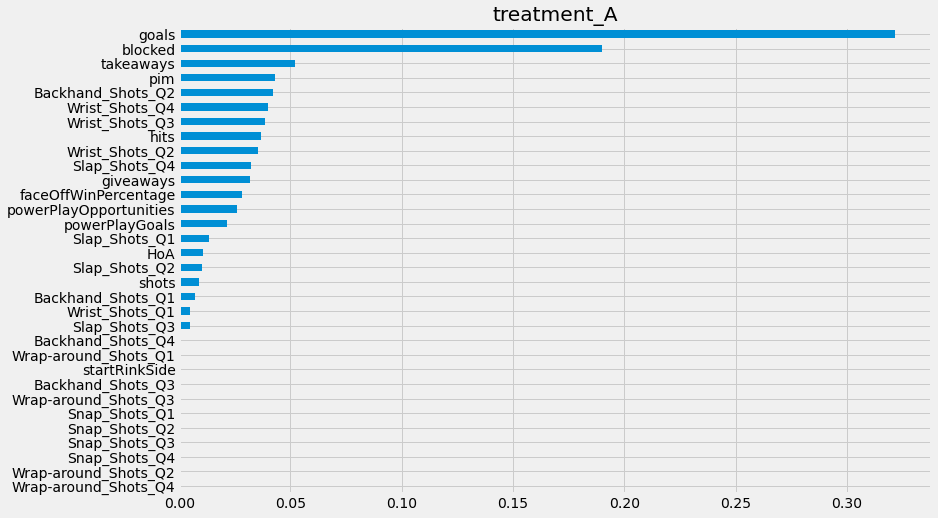

In [100]:
# Auto feature importance plot from Github example.
slearner.plot_importance(X=X,
                        tau=slearner_tau,
                        normalize = True,
                        method = 'auto',
                        features = feature_names)

In [101]:
# Also of interest, if you are a team that is at home or away, it doesn't seem to have a large influence on a 
# team winning the game.

In [102]:
# Permutation method
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': goals                     0.924289
 blocked                   0.456265
 Backhand_Shots_Q2         0.233744
 Wrist_Shots_Q2            0.221691
 takeaways                 0.185971
 Slap_Shots_Q4             0.128766
 Wrist_Shots_Q4            0.120421
 giveaways                 0.099205
 pim                       0.089939
 hits                      0.086707
 Wrist_Shots_Q3            0.081418
 HoA                       0.076295
 faceOffWinPercentage      0.066798
 powerPlayOpportunities    0.059766
 powerPlayGoals            0.055106
 shots                     0.032791
 Slap_Shots_Q1             0.030872
 Backhand_Shots_Q1         0.022703
 Slap_Shots_Q2             0.022662
 Slap_Shots_Q3             0.013913
 Wrist_Shots_Q1            0.008746
 Wrap-around_Shots_Q1      0.000358
 Backhand_Shots_Q4         0.000118
 startRinkSide             0.000061
 Backhand_Shots_Q3         0.000000
 Snap_Shots_Q1             0.000000
 Snap_Shots_Q2             0.000000
 Snap_Shots_Q

In [103]:
# So from both of these feature importance methods, snap shots have very little value on prediciting the outcome
# of a game. This graph is useful as it indicates that most shots are useless predictors but certain Slap_Shots and Wrist_Shots are valuable. 

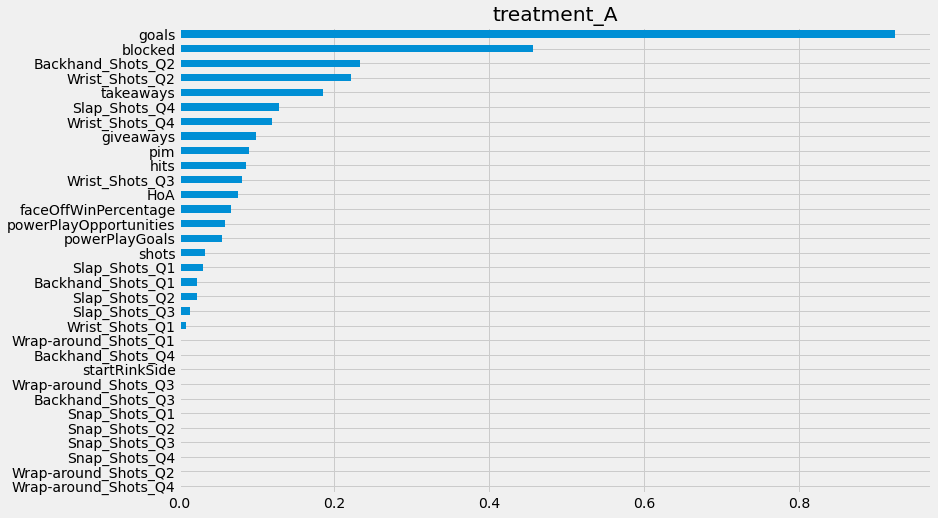

In [104]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

In [105]:
# This graph is telling me that goals, blocked takeaways, giveaways, Slap_Shots_Q4, Backhand_Q2 and Wrist_Q2, pim are the most important
# predictors when determining who will win a game. Many different types of shots and where those shots were
# taken do not matter. Also, interestingly many different types of shots are just noise in our dataset alongside startrinkside
# as they provide no value for make predictions with our model. 

## Shapley Values from Github example

In [106]:
# SHAP values, (SHapley Additive exPlanations) is a technique to interpret-black-box models. This method determines
# how each variable contributed to the model's predictive capabaility. Shap also takes into account the interaction
# between variables. The SHAP scores seen below are based on how that variable has interacted with other variables.

In [107]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 1.18330180e-03,  5.08702001e-03,  9.27748927e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.47774836e-03, -1.23232083e-02,  1.13869995e-03, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.65719582e-04, -2.03790077e-02,  3.74917209e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-4.71844340e-04,  2.87966992e-03, -2.69474564e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 8.49028885e-04,  4.27180201e-03,  9.88797760e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.83757184e-04,  4.21137938e-03,  1.08729834e-04, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])}

In [108]:
np.mean(np.abs(shap_slearner['treatment_A']),axis=0)

array([1.31093033e-03, 5.74676879e-03, 2.82375429e-04, 8.75572613e-04,
       6.34529091e-04, 4.42801577e-04, 5.44348508e-04, 1.01251960e-03,
       7.96324997e-04, 1.24439974e-03, 2.70763198e-03, 1.20336757e-06,
       2.99330890e-04, 2.34105057e-04, 1.96207206e-04, 6.80316947e-04,
       5.79131981e-05, 1.26043660e-03, 9.10188903e-04, 8.59174809e-04,
       7.39505740e-04, 1.41544648e-03, 4.53910857e-07, 4.05406998e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.98262272e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

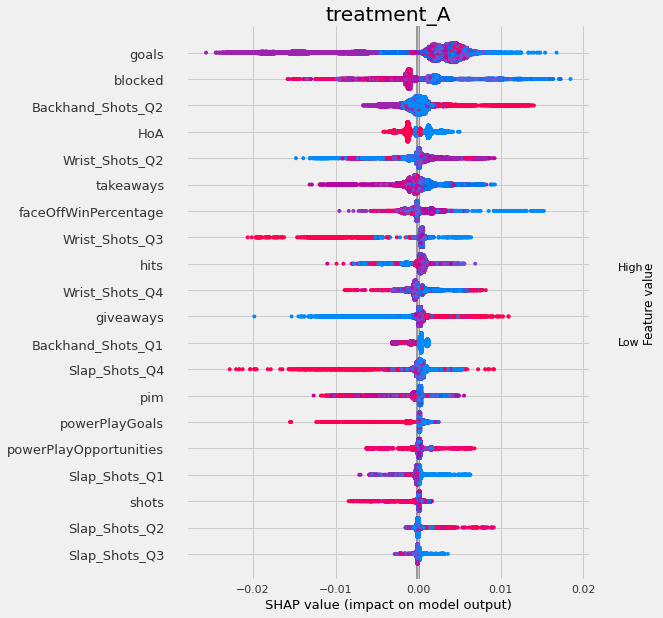

In [109]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

In [110]:
### Interpreting a SHAP summary plot. 
# The y-axis is the order of importance for each variable. Each of them also has a mean sharp value. 
# The x-axis is the SHAP value, which is how much is the change in log-odds. Each point is a observation from
# the orginial dataset. 

# So on to my SHAP graph for my dataset. Goals is the most important predictor for if a team wins a game, followed by 
# blocked shots. Red means the value is high and blue means the value is low. There is alot of
# purple on the left, indicating that lower amounts of goals do not nessecarily determine who will win a game. This could be a result of 
# intense competition within hockey games. On the right the graph is more clear. Higher values of goals leads to increases in chances
# of winning. In otherwords, you are more likely to win if you score more goals. (Even as I am writing this, all I
# can think of is that anyone I could tell this too would just say "Well duh"). But it also seems that if a team scores many goals, this could lower
# chances to win a game. Again, intense games where both teams score many goals could lead to this outcome. There are more interesting
# insights in this graph. BackHandShots in Q1 and Slap_Shots in Q4 are very interesting. If a team takes more Backhands in Q2, which would be the top left of the ice rink from my prespective, the team
# is more likely to win the game. And if they take less Slap_Shots in Q4, they are more likely to win the game. 

# There are other unique insights in this graph as well. I believe that some of these values may be due to the dataset
# and not a reflection of hockey games. For example, PowerPlayGoals says that more goals scored during powerplays
# increases the chances to win. Teams that are Home also seem to loss more which contradicts established research.
# This model requires more analysis to indicate why these variables appear in this manner. 

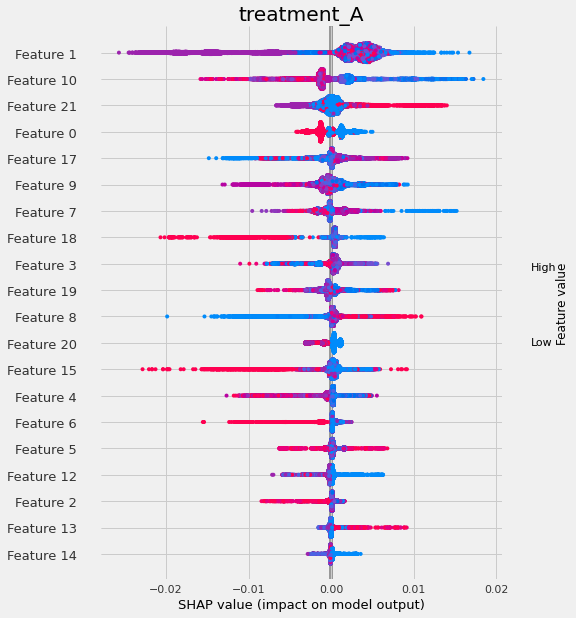

In [111]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

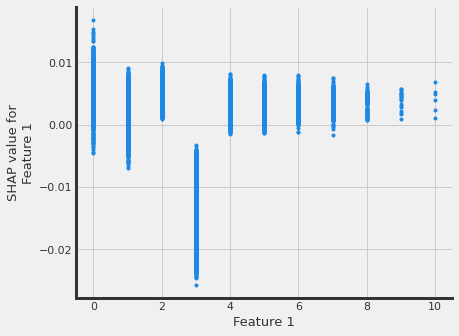

In [112]:
# interaction_idx set to None (no color coding for interaction effects)
# For feature 1, which is Goals
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)
# A Shap dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by
# the model. For this graph, the odds of taking more than 25 shots increases as a team scores more goals.
# But notably, the chances of taking more than 25 shots decreases if a team has scored only three goals. 
# This could be the case that a game with only three goals is very competitive and that there are less 
# opportunities to take a shot on net. 

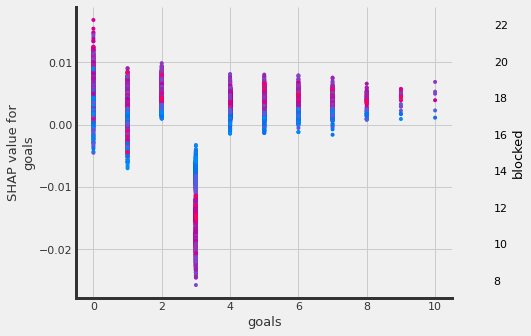

In [113]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='goals',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)
# This graphed indicates that blocked and shots had the most interaction amoung all the variables.

### Uplift Tree/Forest
### I am implementing this portion of the Github example as I am curious what results it will produce.

In [114]:
from causalml.dataset import make_uplift_classification

In [115]:
# When I ran this code the first time, I was unable to execute
# it due to Null values. So for this classifier they must be
# be dropped.

New_cdf = cdf.dropna()
x_name = {"HoA","goals","shots","hits","pim","powerPlayOpportunities","powerPlayOpportunities","powerPlayGoals",
        "faceOffWinPercentage","giveaways","takeaways","blocked","startRinkSide","Slap_Shots_Q1","Slap_Shots_Q2"
        ,"Slap_Shots_Q3","Slap_Shots_Q4","Wrist_Shots_Q1","Wrist_Shots_Q2","Wrist_Shots_Q3","Wrist_Shots_Q4"
        ,"Backhand_Shots_Q1","Backhand_Shots_Q2","Backhand_Shots_Q3","Backhand_Shots_Q4","Snap_Shots_Q1"
        ,"Snap_Shots_Q2","Snap_Shots_Q3","Snap_Shots_Q4","Wrap-around_Shots_Q1","Wrap-around_Shots_Q2"
        ,"Wrap-around_Shots_Q3","Wrap-around_Shots_Q4"}
New_cdf, x_name = make_uplift_classification()
uplift_tree = UpliftTreeClassifier(control_name='control')
uplift_tree.fit(X=New_cdf[x_name].values,
                treatment=New_cdf['treatment_group_key'].values,
                y=New_cdf['conversion'].values)


<AxesSubplot:>

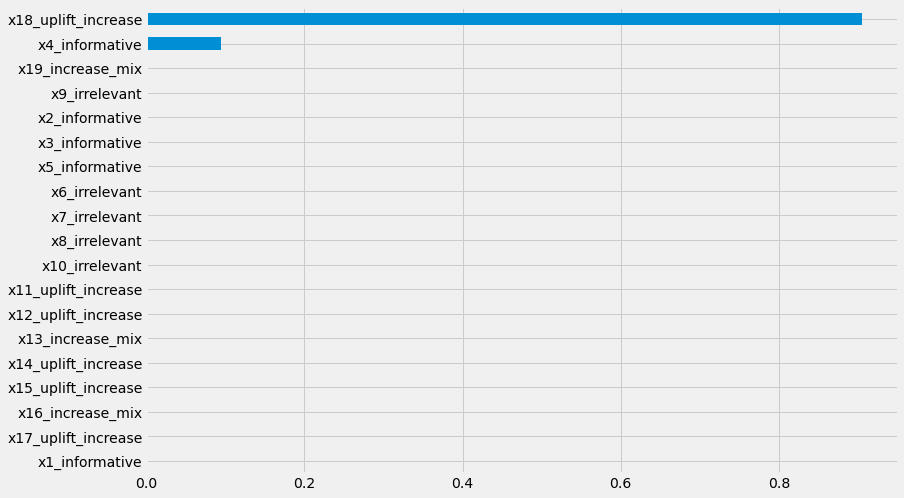

In [116]:
pd.Series(uplift_tree.feature_importances_, index=x_name).sort_values().plot(kind='barh', figsize=(12,8))

### Uplift Tree Forest did not provide very useful results so for fun, I will experiment with XGBoost

In [117]:
# Using code the Github example Meta-Learner
# Calling the Base Learner class and feeding in XGB
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
# Converting Treatment back to 1 and 0 so XGBoost can run
cdf.Treatment = cdf.Treatment.replace({"treatment_A":1,"control":0})
w_multi = cdf.Treatment

# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=w_multi, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

### Just for fun, as the github example uses multiple learners, I will run them as well to see what happens.

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=w_multi, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=w_multi, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([-0.05225537]), array([-0.05938016]), array([-0.04513058]))

Using the BaseTRegressor class and using XGB (same result):
(array([-0.05225537]), array([-0.05938016]), array([-0.04513058]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([-0.00929025]), array([-0.02143923]), array([0.00285873]))


In [118]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
e = cdf.propensity
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=w_multi, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=w_multi, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([-0.06622974]), array([-0.07298547]), array([-0.05947401]))

Using the BaseXRegressor class and using Linear Regression:
(array([-0.00929025]), array([-0.02143923]), array([0.00285873]))


### Calculating Individual Treatment Effect

In [119]:
from causalml.inference.meta import LRSRegressor
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=w_multi, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=w_multi, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=w_multi, y=y,p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=w_multi, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=w_multi, y=y,p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=w_multi, y=y)

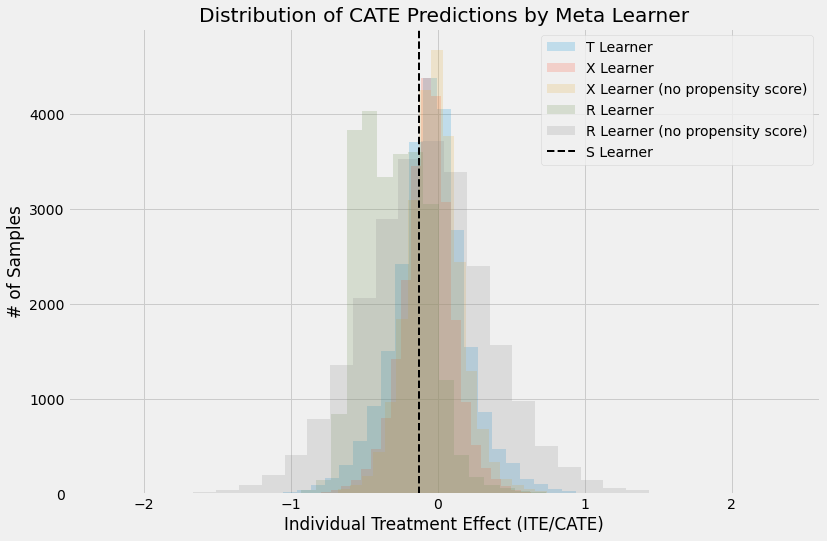

In [120]:
# Graphing the work above
# The S Learner dotted line for comparison would not graph so I had to graph its value manually
# with an axvline
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.axvline(x=-0.130 ,color="black", linestyle="--", label = "S Learner", linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

In [121]:
# The S-Learner which is the base off our model estimates the target variables using all features and treatment
# indicator. The S stands for single as this estimate is done once. A T-Learner estimates the response functions
# separately between treatment and control. (T stands for two). An X Learner is like T-learner expecpts that it 
# tries to avoid overfitting. It uses the control group to better understand the treatment group and vice versa.
# This is where the name X comes from. Finally, an R learner estimates marginal effects and treatment propensity to
# form an objective function that isolates the causal component of the signal.

# From all of this, a CATE is the conditional average treatment effects of all the Meta Learners. CATE is an extension
# of ATE, as it compares each score for each individual team and compares their average scores. Fro, this graph
# it appears that an X Learner with no propensity score is the best method for predicition given that that is has
# the highest score.